# ViT-Base vs ViT-Small Comparison (Dual GPU)

**Setup:** 2 workers, 1 GPU each
- GPU 0: ViT-Small
- GPU 1: ViT-Base

**Previous result:** ViT-Small achieved 69.22% with 10 epochs (from ablation study)

In [1]:
## 1. Download Test Labels
!gdown "1Xv2CWOqdBj3kt0rkNJKRsodSIEd3-wX_" -O test_labels.csv -q
print("Downloaded test_labels.csv")

Downloaded test_labels.csv


In [2]:
%%writefile worker_vit_small.py
#!/usr/bin/env python3
"""Worker GPU 0 - ViT-Small"""
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('transformers').setLevel(logging.ERROR)

import random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import get_cosine_schedule_with_warmup
import pandas as pd
from sklearn.metrics import accuracy_score
import timm
import time
import gc

# Config
PATH_TRAIN = Path('/kaggle/input/action-video/data/data_train')
PATH_TEST = Path('/kaggle/input/action-video/data/test')
MODEL_NAME = 'vit_small_patch16_224'
NUM_FRAMES, IMG_SIZE, RESIZE = 16, 224, 256
BATCH, ACCUM, EPOCHS, LR, WD = 20, 2, 10, 5e-5, 0.05
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
device = torch.device('cuda:0')

class ViT(nn.Module):
    def __init__(self, model_name, nc):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.head = nn.Linear(self.vit.num_features, nc)
    def forward(self, x):
        B,T,C,H,W = x.shape
        return self.head(self.vit(x.view(B*T,C,H,W)).view(B,T,-1).mean(1))

class DS(Dataset):
    def __init__(self, root, train=True):
        self.root, self.train = Path(root), train
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.c2i = {c:i for i,c in enumerate(self.classes)}
        self.samples = [(v, self.c2i[c]) for c in self.classes for v in (self.root/c).iterdir() if v.is_dir()]
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        v, l = self.samples[i]
        fs = sorted(v.glob('*.jpg'))
        idx = torch.linspace(0, len(fs)-1, NUM_FRAMES).long()
        fr = [TF.resize(Image.open(fs[j]).convert('RGB'), RESIZE) for j in idx]
        if self.train:
            i,j,h,w = T.RandomResizedCrop.get_params(fr[0], (0.8,1.0), (0.75,1.33))
            fl = random.random() > 0.5
            return torch.stack([TF.normalize(TF.to_tensor(TF.hflip(TF.resized_crop(f,i,j,h,w,(IMG_SIZE,IMG_SIZE))) if fl else TF.resized_crop(f,i,j,h,w,(IMG_SIZE,IMG_SIZE))), MEAN, STD) for f in fr]), l
        return torch.stack([TF.normalize(TF.to_tensor(TF.center_crop(f, IMG_SIZE)), MEAN, STD) for f in fr]), l

class TDS(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.samples = sorted([(d,int(d.name)) for d in self.root.iterdir() if d.is_dir()], key=lambda x:x[1])
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        v, vid = self.samples[i]
        fs = sorted(v.glob('*.jpg'))
        idx = torch.linspace(0, len(fs)-1, NUM_FRAMES).long()
        fr = [TF.resize(Image.open(fs[j]).convert('RGB'), RESIZE) for j in idx]
        return torch.stack([TF.normalize(TF.to_tensor(TF.center_crop(f, IMG_SIZE)), MEAN, STD) for f in fr]), vid

def train(m, ld, opt, sch, sc):
    m.train()
    loss_s, cor, tot = 0.0, 0, 0
    for bi, (x, y) in enumerate(ld):
        x, y = x.to(device), y.to(device)
        with torch.amp.autocast('cuda'):
            lo = m(x)
            loss = F.cross_entropy(lo, y)
        cor += (lo.argmax(1)==y).sum().item()
        tot += y.size(0)
        loss_s += loss.item() * y.size(0)
        sc.scale(loss/ACCUM).backward()
        if (bi+1) % ACCUM == 0:
            sc.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
            sc.step(opt); sc.update(); opt.zero_grad(); sch.step()
    return loss_s/tot, cor/tot

def evalu(m, ld):
    m.eval()
    ps = []
    with torch.no_grad():
        for x, ids in ld:
            lo = m(x.to(device))
            ps.extend(zip(ids.tolist(), lo.argmax(1).cpu().tolist()))
    return ps

def main():
    gt = dict(zip(pd.read_csv('test_labels.csv')['id'].astype(str), pd.read_csv('test_labels.csv')['class']))
    random.seed(42); np.random.seed(42); torch.manual_seed(42)
    
    tds = DS(PATH_TRAIN, train=True)
    tes = TDS(PATH_TEST)
    cn = tds.classes
    
    m = ViT(MODEL_NAME, len(cn)).to(device)
    print(f"[GPU0] ViT-Small: {sum(p.numel() for p in m.parameters()):,} params")
    
    tl = DataLoader(tds, BATCH, shuffle=True, num_workers=2, drop_last=True)
    tel = DataLoader(tes, BATCH, num_workers=2)
    opt = torch.optim.AdamW(m.parameters(), lr=LR, weight_decay=WD)
    sc = torch.amp.GradScaler()
    sch = get_cosine_schedule_with_warmup(opt, int(len(tl)*EPOCHS*0.1/ACCUM), len(tl)*EPOCHS//ACCUM)
    
    history = []
    best_acc = 0
    
    print(f"\n[GPU0] Training ViT-Small...")
    for ep in range(1, EPOCHS+1):
        ep_start = time.time()
        l, a = train(m, tl, opt, sch, sc)
        ps = evalu(m, tel)
        ta = accuracy_score([gt[str(i)] for i,_ in ps], [cn[p] for _,p in ps])
        ep_time = time.time() - ep_start
        eta = ep_time * (EPOCHS - ep)
        
        if ta > best_acc:
            best_acc = ta
            print(f"  [GPU0] Ep{ep}/{EPOCHS}: L={l:.4f}, Atr={a:.4f}, Ate={ta:.4f} >>> BEST | {ep_time//60:.0f}m{ep_time%60:.0f}s | ETA: {eta//60:.0f}m{eta%60:.0f}s")
        else:
            print(f"  [GPU0] Ep{ep}/{EPOCHS}: L={l:.4f}, Atr={a:.4f}, Ate={ta:.4f} | {ep_time//60:.0f}m{ep_time%60:.0f}s | ETA: {eta//60:.0f}m{eta%60:.0f}s")
        
        history.append({'epoch': ep, 'loss': l, 'train_acc': a, 'test_acc': ta})
        gc.collect(); torch.cuda.empty_cache()
    
    print(f"\n[GPU0] ViT-Small FINAL BEST: {best_acc:.4f}")
    pd.DataFrame(history).to_csv('results_vit_small.csv', index=False)
    print("Saved results_vit_small.csv")

if __name__ == '__main__': main()

Overwriting worker_vit_small.py


In [3]:
%%writefile worker_vit_base.py
#!/usr/bin/env python3
"""Worker GPU 1 - ViT-Base"""
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('transformers').setLevel(logging.ERROR)

import random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import get_cosine_schedule_with_warmup
import pandas as pd
from sklearn.metrics import accuracy_score
import timm
import time
import gc

# Config
PATH_TRAIN = Path('/kaggle/input/action-video/data/data_train')
PATH_TEST = Path('/kaggle/input/action-video/data/test')
MODEL_NAME = 'vit_base_patch16_224'
NUM_FRAMES, IMG_SIZE, RESIZE = 16, 224, 256
BATCH, ACCUM, EPOCHS, LR, WD = 12, 2, 10, 5e-5, 0.05
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
device = torch.device('cuda:0')

class ViT(nn.Module):
    def __init__(self, model_name, nc):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.head = nn.Linear(self.vit.num_features, nc)
    def forward(self, x):
        B,T,C,H,W = x.shape
        return self.head(self.vit(x.view(B*T,C,H,W)).view(B,T,-1).mean(1))

class DS(Dataset):
    def __init__(self, root, train=True):
        self.root, self.train = Path(root), train
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.c2i = {c:i for i,c in enumerate(self.classes)}
        self.samples = [(v, self.c2i[c]) for c in self.classes for v in (self.root/c).iterdir() if v.is_dir()]
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        v, l = self.samples[i]
        fs = sorted(v.glob('*.jpg'))
        idx = torch.linspace(0, len(fs)-1, NUM_FRAMES).long()
        fr = [TF.resize(Image.open(fs[j]).convert('RGB'), RESIZE) for j in idx]
        if self.train:
            i,j,h,w = T.RandomResizedCrop.get_params(fr[0], (0.8,1.0), (0.75,1.33))
            fl = random.random() > 0.5
            return torch.stack([TF.normalize(TF.to_tensor(TF.hflip(TF.resized_crop(f,i,j,h,w,(IMG_SIZE,IMG_SIZE))) if fl else TF.resized_crop(f,i,j,h,w,(IMG_SIZE,IMG_SIZE))), MEAN, STD) for f in fr]), l
        return torch.stack([TF.normalize(TF.to_tensor(TF.center_crop(f, IMG_SIZE)), MEAN, STD) for f in fr]), l

class TDS(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.samples = sorted([(d,int(d.name)) for d in self.root.iterdir() if d.is_dir()], key=lambda x:x[1])
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        v, vid = self.samples[i]
        fs = sorted(v.glob('*.jpg'))
        idx = torch.linspace(0, len(fs)-1, NUM_FRAMES).long()
        fr = [TF.resize(Image.open(fs[j]).convert('RGB'), RESIZE) for j in idx]
        return torch.stack([TF.normalize(TF.to_tensor(TF.center_crop(f, IMG_SIZE)), MEAN, STD) for f in fr]), vid

def train(m, ld, opt, sch, sc):
    m.train()
    loss_s, cor, tot = 0.0, 0, 0
    for bi, (x, y) in enumerate(ld):
        x, y = x.to(device), y.to(device)
        with torch.amp.autocast('cuda'):
            lo = m(x)
            loss = F.cross_entropy(lo, y)
        cor += (lo.argmax(1)==y).sum().item()
        tot += y.size(0)
        loss_s += loss.item() * y.size(0)
        sc.scale(loss/ACCUM).backward()
        if (bi+1) % ACCUM == 0:
            sc.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
            sc.step(opt); sc.update(); opt.zero_grad(); sch.step()
    return loss_s/tot, cor/tot

def evalu(m, ld):
    m.eval()
    ps = []
    with torch.no_grad():
        for x, ids in ld:
            lo = m(x.to(device))
            ps.extend(zip(ids.tolist(), lo.argmax(1).cpu().tolist()))
    return ps

def main():
    gt = dict(zip(pd.read_csv('test_labels.csv')['id'].astype(str), pd.read_csv('test_labels.csv')['class']))
    random.seed(42); np.random.seed(42); torch.manual_seed(42)
    
    tds = DS(PATH_TRAIN, train=True)
    tes = TDS(PATH_TEST)
    cn = tds.classes
    
    m = ViT(MODEL_NAME, len(cn)).to(device)
    print(f"[GPU1] ViT-Base: {sum(p.numel() for p in m.parameters()):,} params")
    
    tl = DataLoader(tds, BATCH, shuffle=True, num_workers=2, drop_last=True)
    tel = DataLoader(tes, BATCH, num_workers=2)
    opt = torch.optim.AdamW(m.parameters(), lr=LR, weight_decay=WD)
    sc = torch.amp.GradScaler()
    sch = get_cosine_schedule_with_warmup(opt, int(len(tl)*EPOCHS*0.1/ACCUM), len(tl)*EPOCHS//ACCUM)
    
    history = []
    best_acc = 0
    
    print(f"\n[GPU1] Training ViT-Base...")
    for ep in range(1, EPOCHS+1):
        ep_start = time.time()
        l, a = train(m, tl, opt, sch, sc)
        ps = evalu(m, tel)
        ta = accuracy_score([gt[str(i)] for i,_ in ps], [cn[p] for _,p in ps])
        ep_time = time.time() - ep_start
        eta = ep_time * (EPOCHS - ep)
        
        if ta > best_acc:
            best_acc = ta
            print(f"  [GPU1] Ep{ep}/{EPOCHS}: L={l:.4f}, Atr={a:.4f}, Ate={ta:.4f} >>> BEST | {ep_time//60:.0f}m{ep_time%60:.0f}s | ETA: {eta//60:.0f}m{eta%60:.0f}s")
        else:
            print(f"  [GPU1] Ep{ep}/{EPOCHS}: L={l:.4f}, Atr={a:.4f}, Ate={ta:.4f} | {ep_time//60:.0f}m{ep_time%60:.0f}s | ETA: {eta//60:.0f}m{eta%60:.0f}s")
        
        history.append({'epoch': ep, 'loss': l, 'train_acc': a, 'test_acc': ta})
        gc.collect(); torch.cuda.empty_cache()
    
    print(f"\n[GPU1] ViT-Base FINAL BEST: {best_acc:.4f}")
    pd.DataFrame(history).to_csv('results_vit_base.csv', index=False)
    print("Saved results_vit_base.csv")

if __name__ == '__main__': main()

Overwriting worker_vit_base.py


In [4]:
## 2. Run Both Workers in Parallel
import subprocess
import threading

def stream_output(proc, name):
    """Stream process output in real-time."""
    for line in iter(proc.stdout.readline, ''):
        if line:
            print(f"{line}", end='', flush=True)
    proc.stdout.close()

print("Starting 2 workers in parallel...")
print("GPU 0: ViT-Small")
print("GPU 1: ViT-Base")
print("="*60)

p0 = subprocess.Popen(
    ['python', '-u', 'worker_vit_small.py'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)
p1 = subprocess.Popen(
    ['python', '-u', 'worker_vit_base.py'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

t0 = threading.Thread(target=stream_output, args=(p0, 'GPU0'))
t1 = threading.Thread(target=stream_output, args=(p1, 'GPU1'))

t0.start()
t1.start()

p0.wait()
p1.wait()
t0.join()
t1.join()

print("="*60)
print("Both workers finished!")

Starting 2 workers in parallel...
GPU 0: ViT-Small
GPU 1: ViT-Base
[GPU0] ViT-Small: 21,685,299 params

[GPU0] Training ViT-Small...
[GPU1] ViT-Base: 85,837,875 params

[GPU1] Training ViT-Base...
  [GPU0] Ep1/10: L=3.2997, Atr=0.2239, Ate=0.4137 >>> BEST | 10m45s | ETA: 96m45s
  [GPU1] Ep1/10: L=2.3504, Atr=0.4063, Ate=0.5314 >>> BEST | 14m35s | ETA: 131m11s
  [GPU0] Ep2/10: L=1.2142, Atr=0.6742, Ate=0.6078 >>> BEST | 8m55s | ETA: 71m19s
  [GPU0] Ep3/10: L=0.6465, Atr=0.8258, Ate=0.6314 >>> BEST | 9m5s | ETA: 63m35s
  [GPU1] Ep2/10: L=0.8704, Atr=0.7505, Ate=0.6196 >>> BEST | 14m33s | ETA: 116m24s
  [GPU0] Ep4/10: L=0.3542, Atr=0.9079, Ate=0.6549 >>> BEST | 8m54s | ETA: 53m24s
  [GPU1] Ep3/10: L=0.4215, Atr=0.8764, Ate=0.6373 >>> BEST | 14m31s | ETA: 101m36s
  [GPU0] Ep5/10: L=0.1877, Atr=0.9580, Ate=0.6765 >>> BEST | 9m5s | ETA: 45m24s
  [GPU0] Ep6/10: L=0.0935, Atr=0.9840, Ate=0.6667 | 9m19s | ETA: 37m15s
  [GPU1] Ep4/10: L=0.2099, Atr=0.9335, Ate=0.6667 >>> BEST | 14m28s | ETA: 86m

COMPARISON
ViT-Small Best: 0.6922 (69.22%)
ViT-Base Best:  0.7373 (73.73%)
Difference:     +4.51%


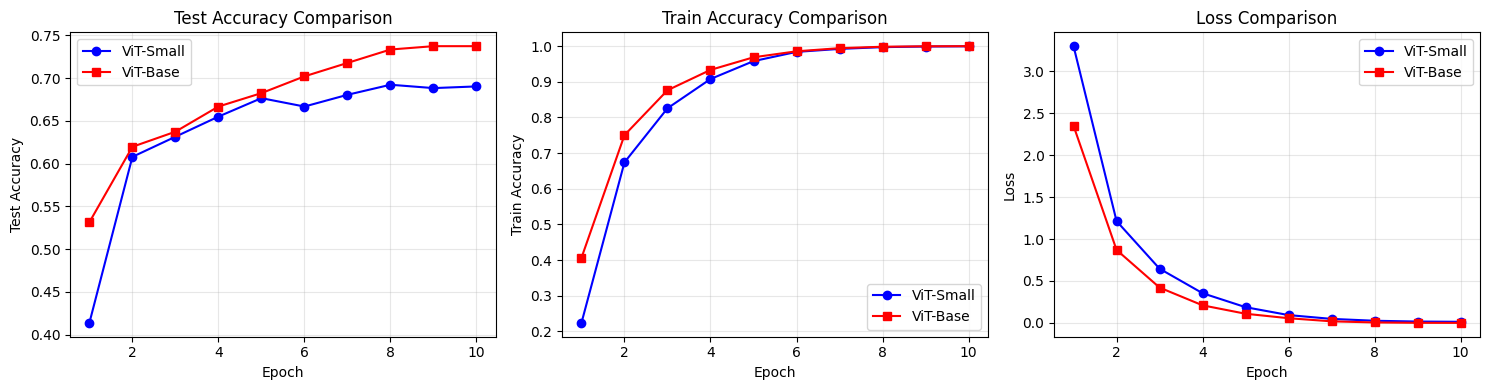


Saved: vit_comparison.csv, vit_comparison.png


In [5]:
## 3. Merge Results and Plot
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df_small = pd.read_csv('results_vit_small.csv')
df_base = pd.read_csv('results_vit_base.csv')

df_small['model'] = 'ViT-Small'
df_base['model'] = 'ViT-Base'

best_small = df_small['test_acc'].max()
best_base = df_base['test_acc'].max()

print("="*60)
print("COMPARISON")
print("="*60)
print(f"ViT-Small Best: {best_small:.4f} ({best_small*100:.2f}%)")
print(f"ViT-Base Best:  {best_base:.4f} ({best_base*100:.2f}%)")
print(f"Difference:     {(best_base - best_small)*100:+.2f}%")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Test Accuracy
axes[0].plot(df_small['epoch'], df_small['test_acc'], 'b-o', label='ViT-Small', ms=6)
axes[0].plot(df_base['epoch'], df_base['test_acc'], 'r-s', label='ViT-Base', ms=6)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Test Accuracy Comparison')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Train Accuracy
axes[1].plot(df_small['epoch'], df_small['train_acc'], 'b-o', label='ViT-Small', ms=6)
axes[1].plot(df_base['epoch'], df_base['train_acc'], 'r-s', label='ViT-Base', ms=6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Train Accuracy')
axes[1].set_title('Train Accuracy Comparison')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Loss
axes[2].plot(df_small['epoch'], df_small['loss'], 'b-o', label='ViT-Small', ms=6)
axes[2].plot(df_base['epoch'], df_base['loss'], 'r-s', label='ViT-Base', ms=6)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Loss Comparison')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('vit_comparison.png', dpi=150)
plt.show()

# Save merged
pd.concat([df_small, df_base]).to_csv('vit_comparison.csv', index=False)
print("\nSaved: vit_comparison.csv, vit_comparison.png")

In [6]:
# Print full history
print("\n--- ViT-Small History ---")
print(df_small[['epoch', 'loss', 'train_acc', 'test_acc']].to_string(index=False))
print("\n--- ViT-Base History ---")
print(df_base[['epoch', 'loss', 'train_acc', 'test_acc']].to_string(index=False))


--- ViT-Small History ---
 epoch     loss  train_acc  test_acc
     1 3.299686   0.223878  0.413725
     2 1.214179   0.674199  0.607843
     3 0.646519   0.825801  0.631373
     4 0.354228   0.907853  0.654902
     5 0.187670   0.958013  0.676471
     6 0.093480   0.983974  0.666667
     7 0.048134   0.992308  0.680392
     8 0.025971   0.997276  0.692157
     9 0.016496   0.999038  0.688235
    10 0.013593   0.999679  0.690196

--- ViT-Base History ---
 epoch     loss  train_acc  test_acc
     1 2.350390   0.406270  0.531373
     2 0.870397   0.750480  0.619608
     3 0.421477   0.876360  0.637255
     4 0.209851   0.933461  0.666667
     5 0.109343   0.968810  0.682353
     6 0.056175   0.985605  0.701961
     7 0.019126   0.994402  0.717647
     8 0.005699   0.998401  0.733333
     9 0.001310   0.999680  0.737255
    10 0.000518   1.000000  0.737255
